In [3]:
import glob 
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from music21 import converter, instrument, note, chord
import time
import pickle


In [ ]:

def get_notes():
    
    notes = []
    
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    for file in glob.glob("midi_songs/*.mid"):
        midi = converter.parse(file)

        #print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)
        
    return notes

In [4]:
notes = get_notes() 

pitchnames = sorted(set(item for item in notes))

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

vocab_size = len(note_to_int)

seq_len = 100

    
in_seq_0 = []
tar_seq_0 = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - seq_len, 1):
    sequence_in = notes[i:i + seq_len]
    sequence_out = notes[i + seq_len]
    
    in_seq_0.append([note_to_int[j] for j in sequence_in])
        
    tar_seq_0.append(note_to_int[sequence_out])
# save the input- and outputsseq to the file 
with open('notes_in', 'wb') as fp:
    pickle.dump(in_seq_0, fp)
    
with open('notes_tar', 'wb') as fp:
    pickle.dump(tar_seq_0, fp)

In [11]:
class LSTM(nn.Module):
    
    def __init__(self, embedding_dim, batch_size, hidden_dim, vocab_size):
        super(LSTM, self).__init__()
        
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=False)
        self.hidden2tag = nn.Linear(hidden_dim, vocab_size)
        self.hidden = self.init_hidden()
        self.softmax = nn.LogSoftmax(dim=1)
        

    def init_hidden(self):

        return (Variable(torch.zeros(1, 1, self.hidden_dim)),
                Variable(torch.zeros(1, 1, self.hidden_dim)))
    
    def forward(self, inputs):
        
        embeds = self.embeddings(inputs)
        lstm_out, self.hidden = self.lstm(embeds.view(100, 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out[:,-1,:])
        pre_scores = self.softmax(tag_space)
        return pre_scores 

In [17]:
embedding_dim = 50
batch_size = 256
hidden_dim = 50

model = LSTM(embedding_dim, batch_size, hidden_dim, vocab_size)

lossfunction = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

Epochs = 1
save_every = 1
print_every = 1

In [18]:
learning_rate = 0.001

def train(in_seq, tar_seq):
    
    hidden = model.init_hidden() 
    
    tar = 0

    for seq in in_seq:
        
        optimizer.zero_grad()
        
        net_in = torch.tensor(seq, dtype=torch.long)
        net_out = torch.narrow(model(net_in), 0, 99, 1)

        target = torch.tensor([tar_seq[tar]], dtype=torch.long)
        tar += 1
        loss = lossfunction(net_out, target)
        loss.backward(retain_graph=True)
        optimizer.step()
    return output, loss.item()

In [19]:
start = time.time()
total_Loss = []

with open ('notes_in', 'rb') as fp:
    in_seq = pickle.load(fp)    
with open ('notes_tar', 'rb') as fp:
    tar_seq = pickle.load(fp)

for e in range(Epochs + 1):
    
    total_Loss.append(0)
    
    output, loss = train(in_seq, tar_seq)
    
    total_Loss[-1] += loss
        
    #save the weights of the Model        
    if e % save_every == 0:
        torch.save(model.state_dict(), f'./net_{e}.pth')
    #print the Loss and Time of the training 
    if e % print_every == 0:   
        print('Epoch {}: Total Loss = {}, Avg. Time/Epoch = {}'
                .format(e, total_Loss[-1], (time.time() - start) / print_every))
        start = time.time()

KeyboardInterrupt: 

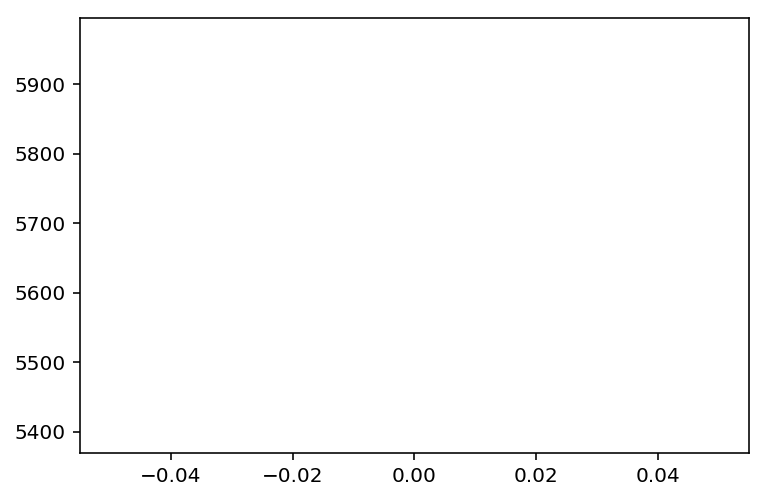

In [53]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(total_Loss)